<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Exponential Smoothing</font></b></strong>

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime
#from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

matplotlib  3.3.0
sklearn     0.23.1
pandas      1.0.5
numpy       1.16.6
statsmodels 0.11.1
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [3]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [5]:
# Random seed 
np.random.seed(7)

## Pré-Processamento

In [6]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

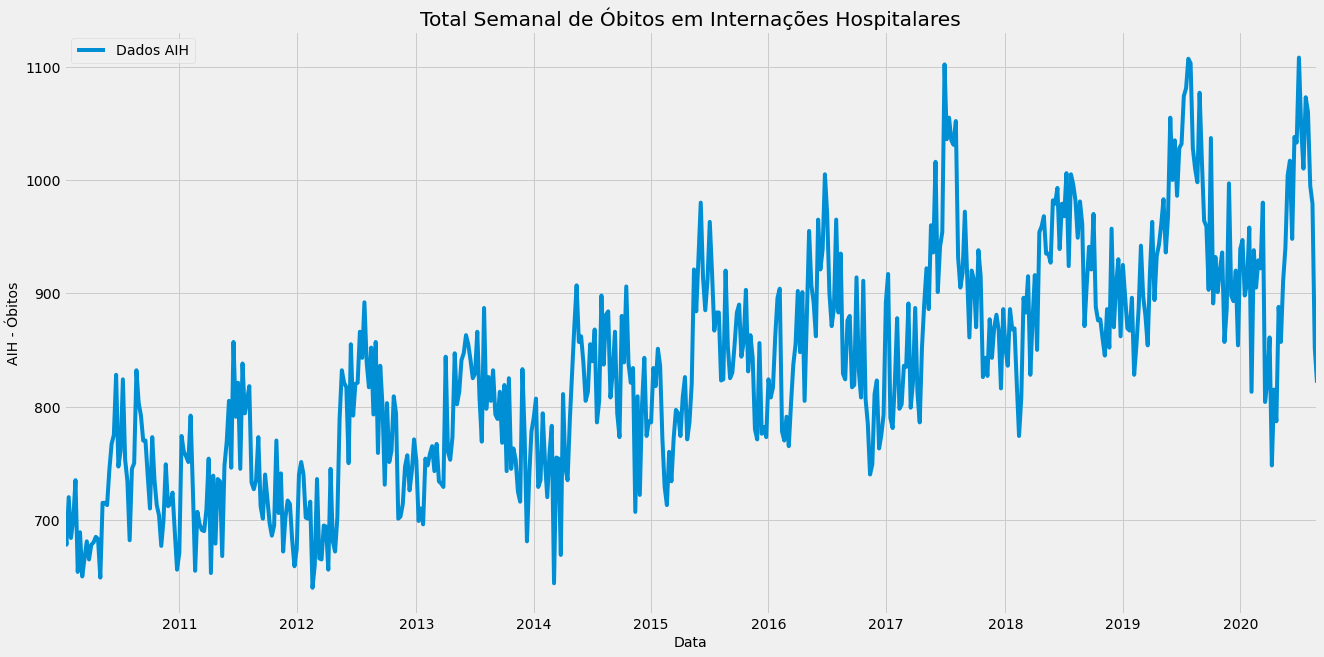

In [7]:
# Plot
target.plot(title = 'Total Semanal de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [8]:
# Os dados de treino serão divididos em dados de treino e teste.
# Observe que os registros são separados em ordem cronológica.
treino = dataframe.iloc[0:417]
teste = dataframe.iloc[417:]
print(len(treino), len(teste))

417 139


## Forecasting - Modelagem Preditiva Para Séries Temporais

### Exponential Smoothing

A suavização exponencial é um método de previsão de séries temporais para dados univariados.



Vamos criar dois modelos de Suavização Exponencial usando o Statsmodels.

In [9]:
# Versão 1 do modelo - Simple Exponential Smoothing
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html

# A função SimpleExpSmoothing() recebe os dados de treino no formato de array numpy
# A função fit() faz o treinamento

# O hiperparâmetro smoothing_level define o nível de suavização exponencial na série
# O hiperparâmetro optimized define se teremos ou não otimização 

# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(np.asarray(treino['QT_INTER'])).fit(smoothing_level = 0.8, optimized = True) 

In [10]:
# Previsões com o Modelo
teste['previsoes_v1'] = modelo_v1.forecast(len(teste)) 

In [11]:
# Colocamos lado a lado, valor real e valor "previsto"
teste[['QT_INTER', 'previsoes_v1']].head()

,QT_INTER,previsoes_v1
Data,,
2018-01-07,851,874.127338
2018-01-14,836,874.127338
2018-01-21,886,874.127338
2018-01-28,868,874.127338
2018-02-04,869,874.127338


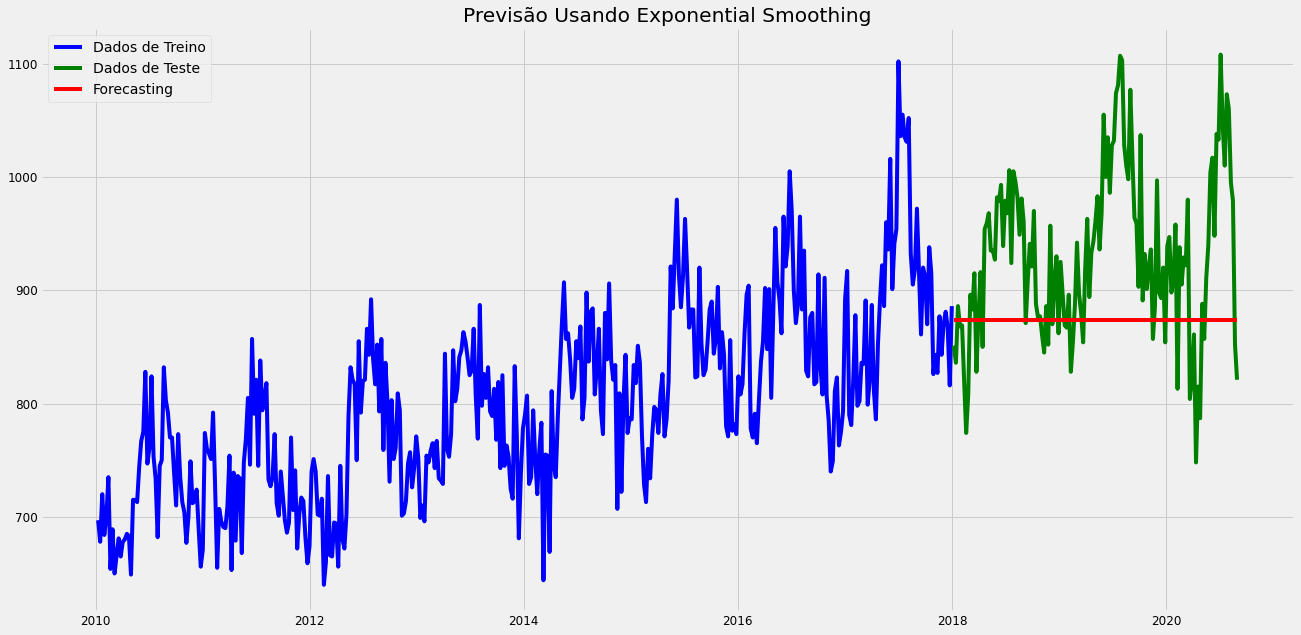

In [12]:
# Plot
plt.figure(figsize = (20, 10))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(treino['QT_INTER'], label = 'Dados de Treino', color = 'blue')
plt.plot(teste['QT_INTER'], label = 'Dados de Teste', color = 'green')
plt.plot(teste['previsoes_v1'], label = 'Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

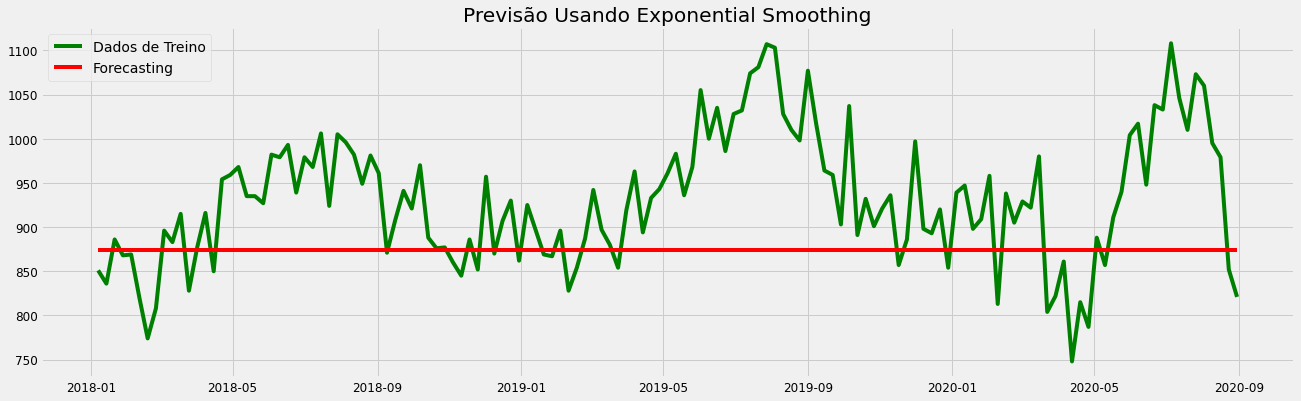

In [13]:
# Plot
plt.figure(figsize = (20, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(teste['QT_INTER'], label = 'Dados de Treino', color = 'green')
plt.plot(teste['previsoes_v1'], label = 'Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

Pronto! Temos a previsão da nossa série! Você apresentaria esse modelo ao investidor disposto a investir no seu negócio? Espero que não!

Esse modelo não é muito melhor do que nosso modelo base. Vamos calcular o erro do modelo.

In [14]:
# Define valor real e valor previsto
y_true = teste.QT_INTER
y_pred = teste.previsoes_v1

In [15]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

92.96919757387232


Nosso Modelo Base com o Método Naive obteve um RMSE de 852.7339. 

Nosso objetivo é reduzir o RMSE tanto quanto possível, pois essa métrica indica a taxa de erro do modelo. 

Aumentou de 86.1777 para 92.9691. 

Ou seja, para essa série, um modelo de suavização exponencial simples não é muito melhor do que um modelo ingênuo (naive).

Será que conseguimos melhorar a performance do modelo preditivo? Vamos tentar outro tipo de suavização exponencial.

In [16]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como temos sazonalidade, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(treino['QT_INTER']), trend = 'additive').fit(smoothing_level = 0.8, 
                                                                                         optimized = True) 

In [17]:
# Previsões com o Modelo
teste['previsoes_v2'] = modelo_v2.forecast(len(teste))

In [18]:
# Colocamos lado a lado, valor real e valor "previsto"
teste[['QT_INTER', 'previsoes_v1', 'previsoes_v2']].head()

,QT_INTER,previsoes_v1,previsoes_v2
Data,,,
2018-01-07,851,874.127338,874.667359
2018-01-14,836,874.127338,875.099377
2018-01-21,886,874.127338,875.531394
2018-01-28,868,874.127338,875.963411
2018-02-04,869,874.127338,876.395429


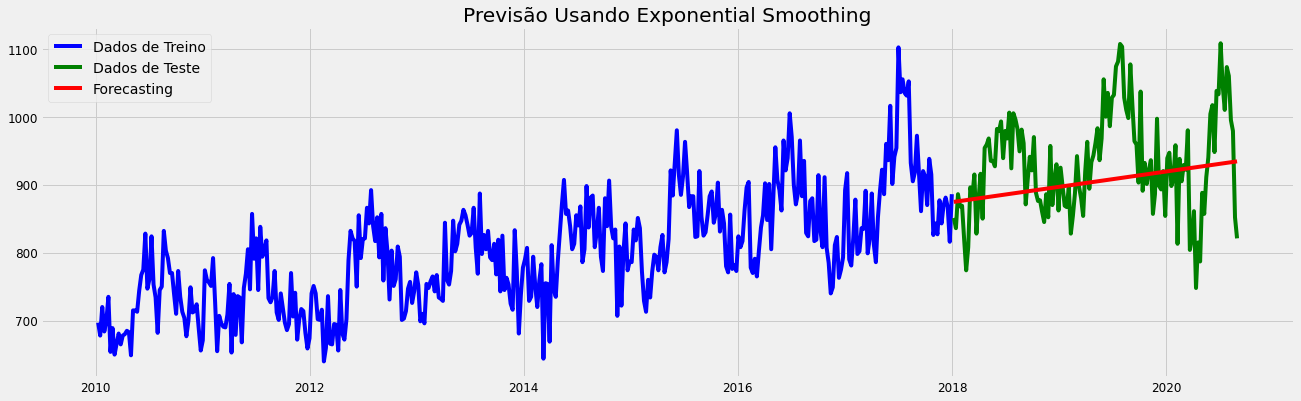

In [19]:
# Plot
plt.figure(figsize = (20, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(treino['QT_INTER'], label = 'Dados de Treino', color = 'blue')
plt.plot(teste['QT_INTER'], label = 'Dados de Teste', color = 'green')
plt.plot(teste['previsoes_v2'], label = 'Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

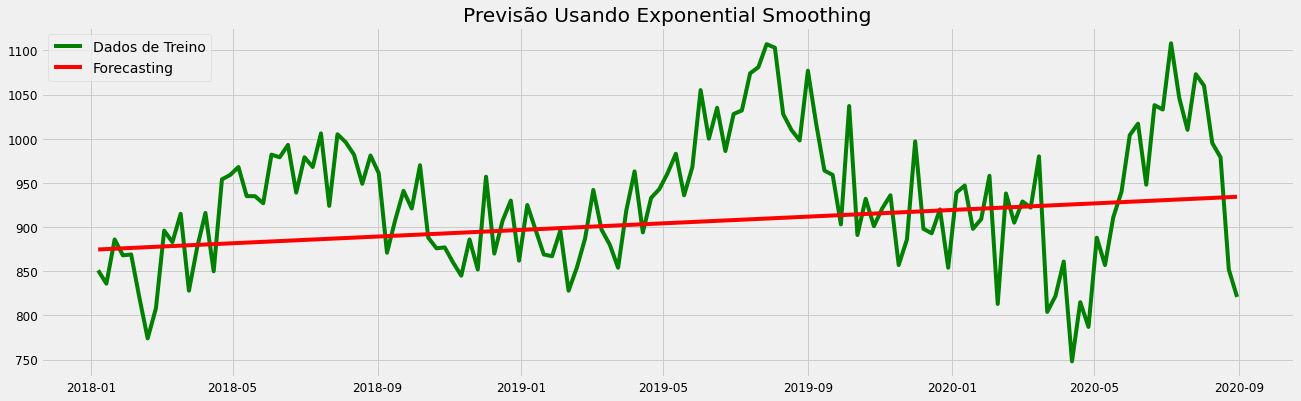

In [20]:
# Plot
plt.figure(figsize = (20, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(teste['QT_INTER'], label = 'Dados de Treino', color = 'green')
plt.plot(teste['previsoes_v2'], label = 'Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

In [21]:
# Define valor real e valor previsto
y_true = teste.QT_INTER
y_pred = teste.previsoes_v2

In [22]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

76.67302183376052


Opa! Tivemos uma piora razoável aqui.

Aumentou de 86.177 (naive) para 92.9691 (previsoes_v1) e reduziu para 76.6730 (previsoes_v2).

Observe a linha vermelha no gráfico. Ela começou a subir. Nosso objetivo é deixá-la semelhante à linha verde. Chegaremos lá.


Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim